In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint as pp
import csv
import datetime
from dateutil.parser import parse
from pandas.tools.plotting import scatter_matrix
from patsy import dmatrices
import statsmodels.formula.api as smf
from sklearn import cross_validation
from sklearn import datasets
from sklearn import svm
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

sns.set_palette("deep", desat=.8)
sns.set_context(rc={"figure.figsize": (14, 8)})

In [195]:
complete_df = pd.read_csv("complete_post2010.csv")

In [196]:
complete_df = complete_df[np.isfinite(complete_df['comments_score'])]
complete_df = complete_df[np.isfinite(complete_df['posts_score'])]
complete_df = complete_df[np.isfinite(complete_df['foreign_gross'])]
complete_df = complete_df[np.isfinite(complete_df['opening_weekend'])]

complete_df["opening_weekend"] = complete_df["opening_weekend"].apply(lambda x: int(x))
complete_df["foreign_gross"] = complete_df["foreign_gross"].apply(lambda x: int(x))
# complete_df["release_date"] = complete_df["release_date"].apply(lambda x: parse(x).date())

complete_df = complete_df[complete_df['comments_score']>0]
complete_df = complete_df[complete_df['posts_score']>0]

complete_df["reddit_buzz"]=complete_df['comments_score']+complete_df["posts_score"]
complete_df["ow_rb"]=complete_df["opening_weekend"]+complete_df["reddit_buzz"]**2
complete_df = complete_df[complete_df['reddit_buzz']>0]
complete_df["opening_weekend_adj"] = complete_df['opening_weekend']*3

In [197]:
complete_df.describe()

,opening_weekend,foreign_gross,posts_score,comments_score,reddit_buzz,ow_rb,opening_weekend_adj
count,5.740000e+02,5.740000e+02,574.000000,574.000000,574.000000,5.740000e+02,5.740000e+02
mean,2.250218e+07,1.103344e+08,5178.818815,31792.092334,36970.911150,4.436918e+09,6.750653e+07
std,2.728470e+07,1.585056e+08,6640.978680,49707.943219,55252.926279,1.336685e+10,8.185411e+07
min,4.712200e+04,6.300000e+02,1.000000,2.000000,3.000000,5.179200e+04,1.413660e+05
25%,6.901067e+06,1.515000e+07,413.000000,1666.750000,2029.000000,2.289054e+07,2.070320e+07
50%,1.442660e+07,4.876004e+07,2275.000000,8881.000000,11438.000000,1.550198e+08,4.327979e+07
75%,2.733144e+07,1.296817e+08,7537.000000,42386.250000,54474.500000,2.971270e+09,8.199432e+07
max,2.074387e+08,9.605000e+08,34121.000000,394250.000000,415019.000000,1.722883e+11,6.223161e+08


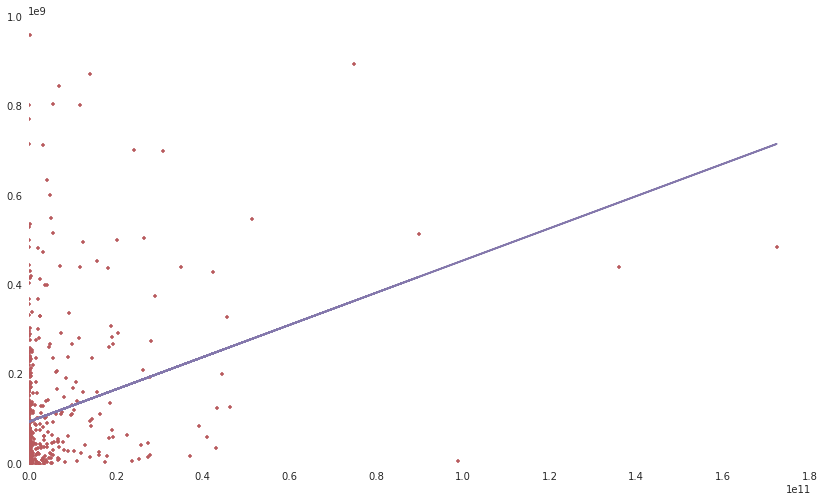

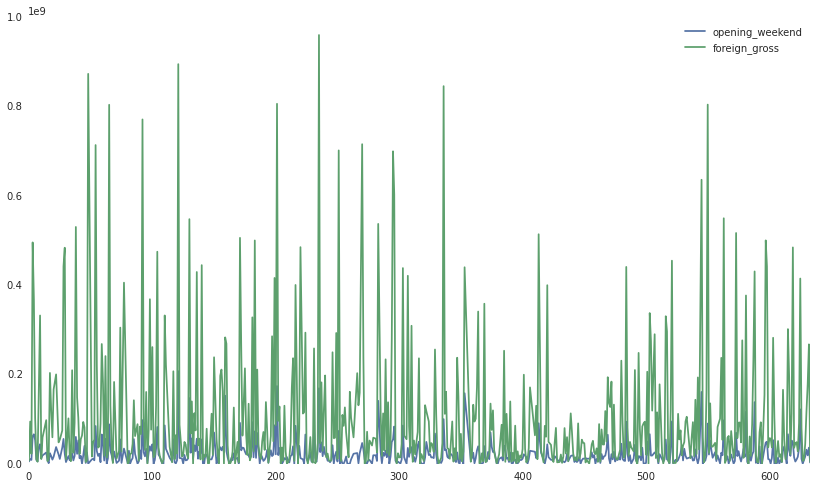

In [207]:
plt.hist(complete_df["foreign_gross"], histtype="stepfilled", alpha=.8)
plt.hist(complete_df["opening_weekend"], histtype="stepfilled", alpha=.8)


# complete_df.plot(x="opening_weekend", y="foreign_gross", style='o')
# complete_df.plot(x="reddit_buzz", y="foreign_gross", style='o')
# complete_df.plot(x="ow_rb", y="foreign_gross", style='o')


x=complete_df["ow_rb"]
y=complete_df["foreign_gross"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')



complete_df[["opening_weekend", "foreign_gross"]].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f8061d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1314c53d0>]], dtype=object)

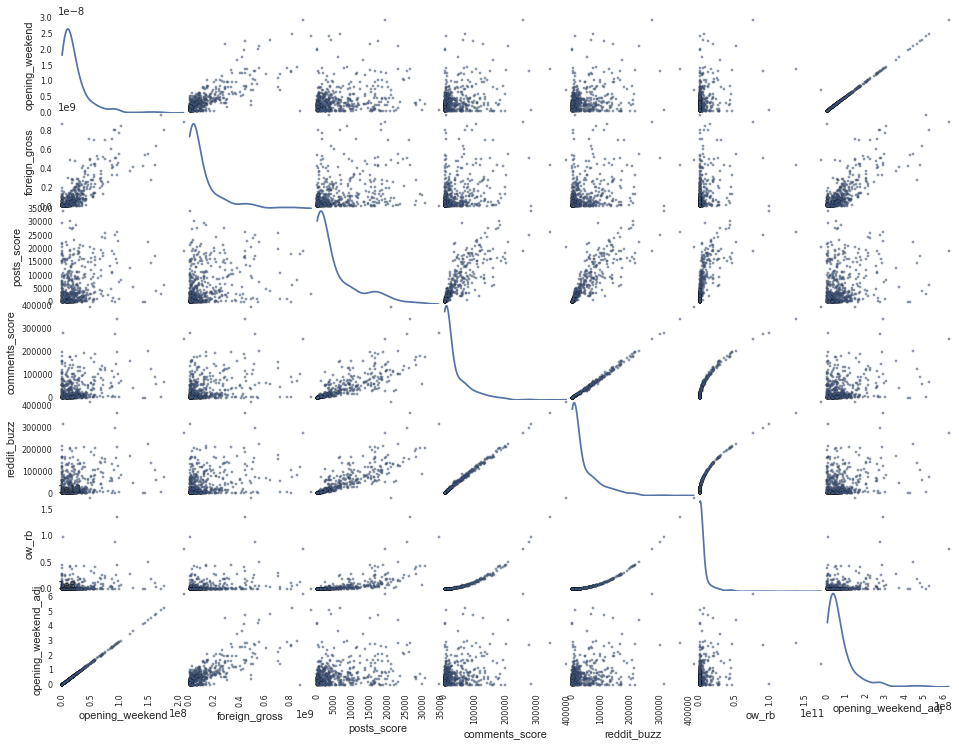

In [173]:
scatter_matrix(complete_df, alpha=0.6, figsize=(16,12), diagonal='kde')

In [174]:
model = smf.ols(formula="foreign_gross ~ opening_weekend", data=complete_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     941.9
Date:                Thu, 23 Apr 2015   Prob (F-statistic):          5.38e-123
Time:                        14:56:06   Log-Likelihood:                -11372.
No. Observations:                 574   AIC:                         2.275e+04
Df Residuals:                     572   BIC:                         2.276e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        7.223e+06   5.28e+06      1.369      0.172     -3.14e+06  1.76e+07
opening_weekend     4.5823      0.149     30.691      0.000         4.289     4.876
==============================================================================
Omnibus:                      358.698   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5858.441
Skew:                           2.453   Prob(JB):                         0.00
Kurtosis:                      17.862   Cond. No.                     4.58e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [175]:
model = smf.ols(formula="foreign_gross ~ opening_weekend + reddit_buzz", data=complete_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     494.7
Date:                Thu, 23 Apr 2015   Prob (F-statistic):          2.26e-125
Time:                        14:56:06   Log-Likelihood:                -11363.
No. Observations:                 574   AIC:                         2.273e+04
Df Residuals:                     571   BIC:                         2.275e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -2.493e+05   5.48e+06     -0.045      0.964      -1.1e+07  1.05e+07
opening_weekend     4.3734      0.155     28.240      0.000         4.069     4.678
reddit_buzz       329.2770     76.474      4.306      0.000       179.072   479.482
==============================================================================
Omnibus:                      354.021   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5576.383
Skew:                           2.422   Prob(JB):                         0.00
Kurtosis:                      17.481   Cond. No.                     4.83e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [176]:
model = smf.ols(formula="foreign_gross ~ opening_weekend + reddit_buzz + ow_rb", data=complete_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     329.4
Date:                Thu, 23 Apr 2015   Prob (F-statistic):          5.09e-124
Time:                        14:56:06   Log-Likelihood:                -11363.
No. Observations:                 574   AIC:                         2.273e+04
Df Residuals:                     570   BIC:                         2.275e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -1.287e+06   5.91e+06     -0.218      0.828     -1.29e+07  1.03e+07
opening_weekend     4.3736      0.155     28.222      0.000         4.069     4.678
reddit_buzz       393.1749    155.660      2.526      0.012        87.437   698.913
ow_rb              -0.0003      0.001     -0.471      0.638        -0.002     0.001
==============================================================================
Omnibus:                      352.211   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5507.583
Skew:                           2.407   Prob(JB):                         0.00
Kurtosis:                      17.391   Cond. No.                     2.07e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [177]:
msk = np.random.rand(len(complete_df)) < 0.8
train = complete_df[msk]
test = complete_df[~msk]
# train["reddit_buzz"]=train['comments_score']+train["posts_score"]
# test["reddit_buzz"]=test['comments_score']+test["posts_score"]
# train.head()
test.head()

,title,opening_weekend,foreign_gross,release_date,posts_score,comments_score,reddit_buzz,ow_rb,opening_weekend_adj
24,Project X,21051363,48000000,2012-03-02,1475,4534,6009,57159444,63154089
33,Delivery Man,7944977,20500000,2013-11-22,453,1761,2214,12846773,23834931
38,Madagascar 3: Europe's Most Wanted,60316738,530529792,2012-06-08,1338,3950,5288,88279682,180950214
43,Rush,187289,63300000,2013-09-20,14717,80640,95357,9093144738,561867
45,Safe House,40172720,81702771,2012-02-10,1381,4028,5409,69430001,120518160


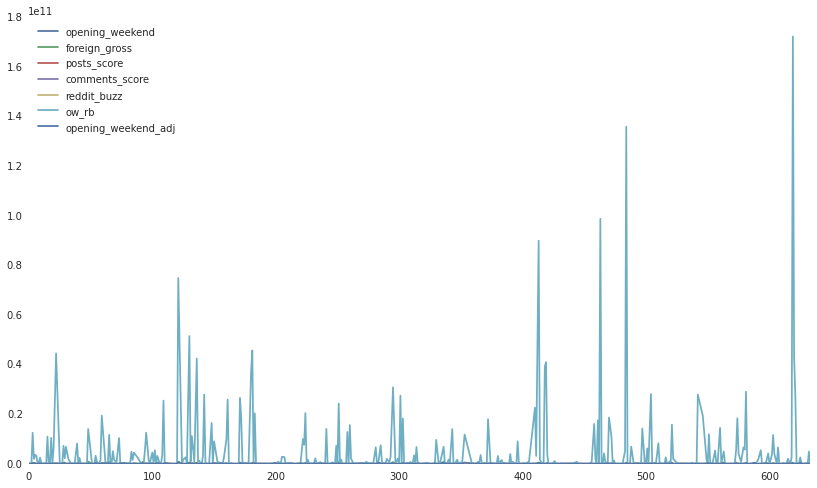

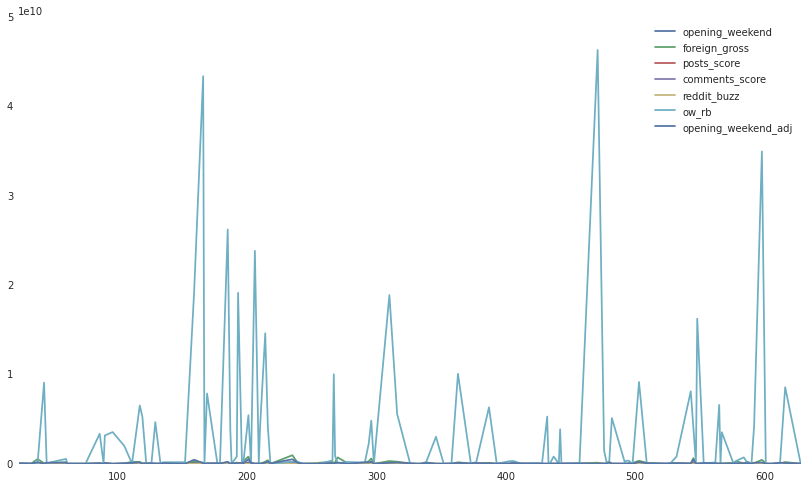

In [178]:
train.plot()
test.plot()

In [179]:
model = smf.ols(formula="foreign_gross ~ opening_weekend + reddit_buzz + ow_rb", data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     241.5
Date:                Thu, 23 Apr 2015   Prob (F-statistic):           4.02e-93
Time:                        14:56:06   Log-Likelihood:                -8931.6
No. Observations:                 451   AIC:                         1.787e+04
Df Residuals:                     447   BIC:                         1.789e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -3.434e+06   6.77e+06     -0.507      0.612     -1.67e+07  9.87e+06
opening_weekend     4.3750      0.186     23.469      0.000         4.009     4.741
reddit_buzz       522.8474    173.850      3.007      0.003       181.183   864.512
ow_rb              -0.0007      0.001     -1.004      0.316        -0.002     0.001
==============================================================================
Omnibus:                      300.957   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4678.550
Skew:                           2.638   Prob(JB):                         0.00
Kurtosis:                      17.871   Cond. No.                     2.26e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [182]:
predictors =  ["opening_weekend", "reddit_buzz", "ow_rb"]
test_df = test[predictors]
test_df = sm.add_constant(test_df)
test_df.head()
y_pred = model.predict(test_df, transform=False)
y_pred[0:10]


array([  9.17682789e+07,   3.24739486e+07,   2.63155653e+08,
         4.10557582e+07,   1.75101918e+08,   1.91074097e+08,
         2.90479955e+07,   1.43600005e+06,   5.44005392e+06,
         1.20756849e+08])